In [21]:
import praw
import pprint
import datetime

In [22]:
reddit = praw.Reddit(client_id = 'h8BBe0NNslxi8g', 
                     client_secret = 'gd2EfD_bd9njZI9zngbiD1WhMJo8lA', 
                     user_agent = 'Chrome:AwardPredictor:v0.0.1 (by /u/drdnm)')

In [23]:
aww = reddit.subreddit('aww')
hist = reddit.subreddit('history')
askred = reddit.subreddit('askreddit')

multi = reddit.subreddit('aww+history+askreddit')

In [26]:
multi_hot = multi.hot(limit = 1)

In [101]:
def submission_features(subm):
    
    # List of potentially informative features available from the API
    api_feat = {'Title': 'title',
                'Author': 'author',
                'ID': 'id',
                'Gilded': 'gilded',
                'Gildings': 'gildings',
                'Upvotes': 'ups',
                'Upvote ratio': 'upvote_ratio',
                'Post time': 'created_utc',
                'Views': 'view_count',
                'Discussion type': 'discussion_type',
                'Distinguished': 'distinguished',
                'Contest mode': 'contest_mode',
                'Content categories': 'content_categories',
                'Edited': 'edited',
                'Hidden': 'hidden',
                'Crosspostable': 'is_crosspostable',
                'Crossposts': 'num_crossposts',
                'Meta': 'is_meta',
                'OC': 'is_original_content',
                'Reddit media': 'is_reddit_media_domain',
                'Robot indexable': 'is_robot_indexable',
                'Selfpost': 'is_self',
                'Video': 'is_video',
                'Likes': 'likes',
                'Comments': 'num_comments',
                'Adult content': 'over_18',
                'Subreddit': 'subreddit',
               }
    
    # Iterate through desired features to build a dictionary containing feature values for this submission
    features = {}
    for feat_name in api_feat:
        features[feat_name] = subm.__dict__[api_feat[feat_name]]
    
    # Extract author and subreddit names as strings
    features['Author'] = features['Author'].name
    features['Subreddit'] = features['Subreddit'].display_name
    
    # Convert UTC timestamp to time of day (in minutes since beginning of UTC day)
    dtime_posted = datetime.datetime.fromtimestamp(features['Post time'])
    features['Post time'] = dtime_posted.hour*60 + dtime_posted.minute
    
    # Calculate age of the post (in minutes)
    features['Post age'] = (datetime.datetime.now() - dtime_posted).total_seconds()/60
    
    # Calculate upvotes per minute of age and comments per minute of age
    features['Upvote rate'] = features['Upvotes']/features['Post age']
    features['Comment rate'] = features['Comments']/features['Post age']
    
    # Extract and process comments
    
    
    return features

In [102]:
submission_features(subm)

{'Title': 'Prison Break',
 'Author': 'pkkballer22',
 'ID': 'k9pemt',
 'Gilded': 7,
 'Gildings': {'gid_1': 253, 'gid_2': 7, 'gid_3': 3},
 'Upvotes': 104355,
 'Upvote ratio': 0.9,
 'Post time': 196,
 'Views': None,
 'Discussion type': None,
 'Distinguished': None,
 'Contest mode': False,
 'Content categories': None,
 'Edited': False,
 'Hidden': False,
 'Crosspostable': False,
 'Crossposts': 37,
 'Meta': False,
 'OC': False,
 'Reddit media': True,
 'Robot indexable': True,
 'Selfpost': False,
 'Video': True,
 'Likes': None,
 'Comments': 1747,
 'Adult content': False,
 'Subreddit': 'aww',
 'Post age': 607.6381998166667,
 'Upvote rate': 171.73870904015817,
 'Comment rate': 2.8750661175138355}

In [127]:
# Deal with comments

def get_toplevel_comment_info(subm, num_1st_level, num_2nd_level):
    
    # 'num_1st_level' controls the number of highest-upvoted top-level comments for which the 2nd level comments will be explored
    # 'num_2nd_level' controls the number of highest-upvoted 2nd-level replies (from amongst the target top-level comments)
    # for which the 3rd-level replies will be explored
    
    
    # Delete all "more comments" entries to avoid errors - puts a cap on max number of comments retrieved
    subm.comments.replace_more(limit = 0) 

    # List of features of interest to pull from the API
    api_feat = {'Author': 'author',
                'Gilded': 'gilded',
                'Gildings': 'gildings',
                'Upvotes': 'ups',
                'Downvotes': 'downs',
                'Distinguished': 'distinguished',
                'Edited': 'edited',
                'Controversiality': 'controversiality',
                'OP comment': 'is_submitter'
               }
    
    # Iterate through all comments to extract their features
    comment_features = {}
    for comment in subm.comments:
        # For each comment build a dict to hold its features, indexed by comment id
        ID = comment.id
        comment_features[ID] = {}
        for feat_name in api_feat:
            comment_features[ID][feat_name] = comment.__dict__[api_feat[feat_name]]
               
        # Calculate Delta t from submission to comment (in minutes)
        comment_dtime = datetime.datetime.fromtimestamp(comment.created_utc)
        subm_dtime = datetime.datetime.fromtimestamp(subm.created_utc)
        comment_features[ID]['Delta t'] = (comment_dtime - subm_dtime).total_seconds()/60
    
    # Calculate number of OP comments (or 2nd or 3rd level replies) in chain.
    
    # Calculate the average number of upvotes received by OP in comments or replies.
        
    # Calculate average number of 2nd-level replies for top-n (5?) comments.
    
    # Calculate the average number of 3rd-level replies to each of the top-m (5?) second-level comments, 
    # for each of the top-n comments.
    
    return comment_features

In [128]:
get_toplevel_comment_info(subm)

{'gf5saq5': {'Author': Redditor(name='mandowillis'),
  'Gilded': 0,
  'Gildings': {},
  'Upvotes': 3830,
  'Downvotes': 0,
  'Distinguished': None,
  'Edited': False,
  'Controversiality': 0,
  'OP comment': False,
  'Delta t': 115.16666666666667},
 'gf5tvrm': {'Author': Redditor(name='Breadsoup'),
  'Gilded': 0,
  'Gildings': {'gid_1': 1},
  'Upvotes': 1374,
  'Downvotes': 0,
  'Distinguished': None,
  'Edited': False,
  'Controversiality': 0,
  'OP comment': False,
  'Delta t': 137.35},
 'gf5o421': {'Author': Redditor(name='kiwikittikat'),
  'Gilded': 0,
  'Gildings': {},
  'Upvotes': 7944,
  'Downvotes': 0,
  'Distinguished': None,
  'Edited': False,
  'Controversiality': 0,
  'OP comment': False,
  'Delta t': 47.56666666666667},
 'gf5rytx': {'Author': Redditor(name='aretasdamon'),
  'Gilded': 0,
  'Gildings': {'gid_1': 1},
  'Upvotes': 3007,
  'Downvotes': 0,
  'Distinguished': None,
  'Edited': False,
  'Controversiality': 0,
  'OP comment': False,
  'Delta t': 110.21666666666667}

In [116]:
subm.comments.__dict__['_comments'][0].__dict__


{'_replies': <praw.models.comment_forest.CommentForest at 0x16313c0bdc0>,
 '_submission': Submission(id='k9pemt'),
 '_reddit': <praw.reddit.Reddit at 0x16313b01c40>,
 'total_awards_received': 1,
 'approved_at_utc': None,
 'comment_type': None,
 'awarders': [],
 'mod_reason_by': None,
 'banned_by': None,
 'ups': 3830,
 'author_flair_type': 'text',
 'removal_reason': None,
 'link_id': 't3_k9pemt',
 'author_flair_template_id': None,
 'likes': None,
 'user_reports': [],
 'saved': False,
 'id': 'gf5saq5',
 'banned_at_utc': None,
 'mod_reason_title': None,
 'gilded': 0,
 'archived': False,
 'no_follow': False,
 'author': Redditor(name='mandowillis'),
 'can_mod_post': False,
 'send_replies': True,
 'parent_id': 't3_k9pemt',
 'score': 3830,
 'author_fullname': 't2_68xkuviy',
 'report_reasons': None,
 'approved_by': None,
 'all_awardings': [{'giver_coin_reward': None,
   'subreddit_id': None,
   'is_new': False,
   'days_of_drip_extension': 0,
   'coin_price': 125,
   'id': 'award_5f123e3d-4f48

In [28]:
for num, comment in enumerate(subm.comments):
    if num < 1:
        pprint.pprint(vars(comment))

{'_fetched': True,
 '_reddit': <praw.reddit.Reddit object at 0x0000016313B01C40>,
 '_replies': <praw.models.comment_forest.CommentForest object at 0x0000016313C0BDC0>,
 '_submission': Submission(id='k9pemt'),
 'all_awardings': [{'award_sub_type': 'GLOBAL',
                    'award_type': 'global',
                    'awardings_required_to_grant_benefits': None,
                    'coin_price': 125,
                    'coin_reward': 0,
                    'count': 1,
                    'days_of_drip_extension': 0,
                    'days_of_premium': 0,
                    'description': 'When you come across a feel-good thing.',
                    'end_date': None,
                    'giver_coin_reward': None,
                    'icon_format': None,
                    'icon_height': 2048,
                    'icon_url': 'https://i.redd.it/award_images/t5_22cerq/5izbv4fn0md41_Wholesome.png',
                    'icon_width': 2048,
                    'id': 'award_5f123e3d-4f

In [8]:
len(subm.comments)

0

In [9]:
ups = []
for j, comment in enumerate(subm.comments):
    if j < 98:
        ups.append(comment.ups)

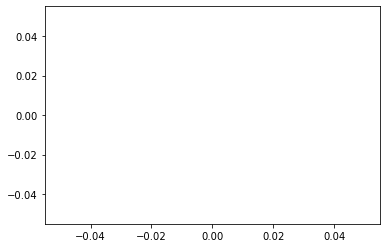

In [10]:
import matplotlib.pyplot as plt

plt.scatter(range(len(ups)), ups)

In [11]:
datetime.datetime.fromtimestamp( int(subm.created_utc) )

datetime.datetime(2020, 12, 9, 10, 9, 30)

In [19]:
(datetime.datetime.now() - datetime.datetime.fromtimestamp( int(subm.created_utc) )).total_seconds()

175.139594

In [14]:
subm.title

'What advice have you given other people that was really about you?'

In [15]:
subm.subreddit

Subreddit(display_name='AskReddit')

In [16]:
subm.author

Redditor(name='kandyda')